# Training AAC

Counter({0: 1200, 1: 1200})
accuracy: 95.17%
recall: 95.00%
prec: 95.32%
f1: 95.16%
Counter({0: 1200, 1: 1200})
accuracy: 94.50%
recall: 96.00%
prec: 93.20%
f1: 94.58%
Counter({0: 1200, 1: 1200})
accuracy: 95.00%
recall: 96.00%
prec: 94.12%
f1: 95.05%
Counter({0: 1200, 1: 1200})
accuracy: 95.50%
recall: 98.00%
prec: 93.33%
f1: 95.61%
Counter({0: 1200, 1: 1200})
accuracy: 95.99%
recall: 95.99%
prec: 95.99%
f1: 95.99%


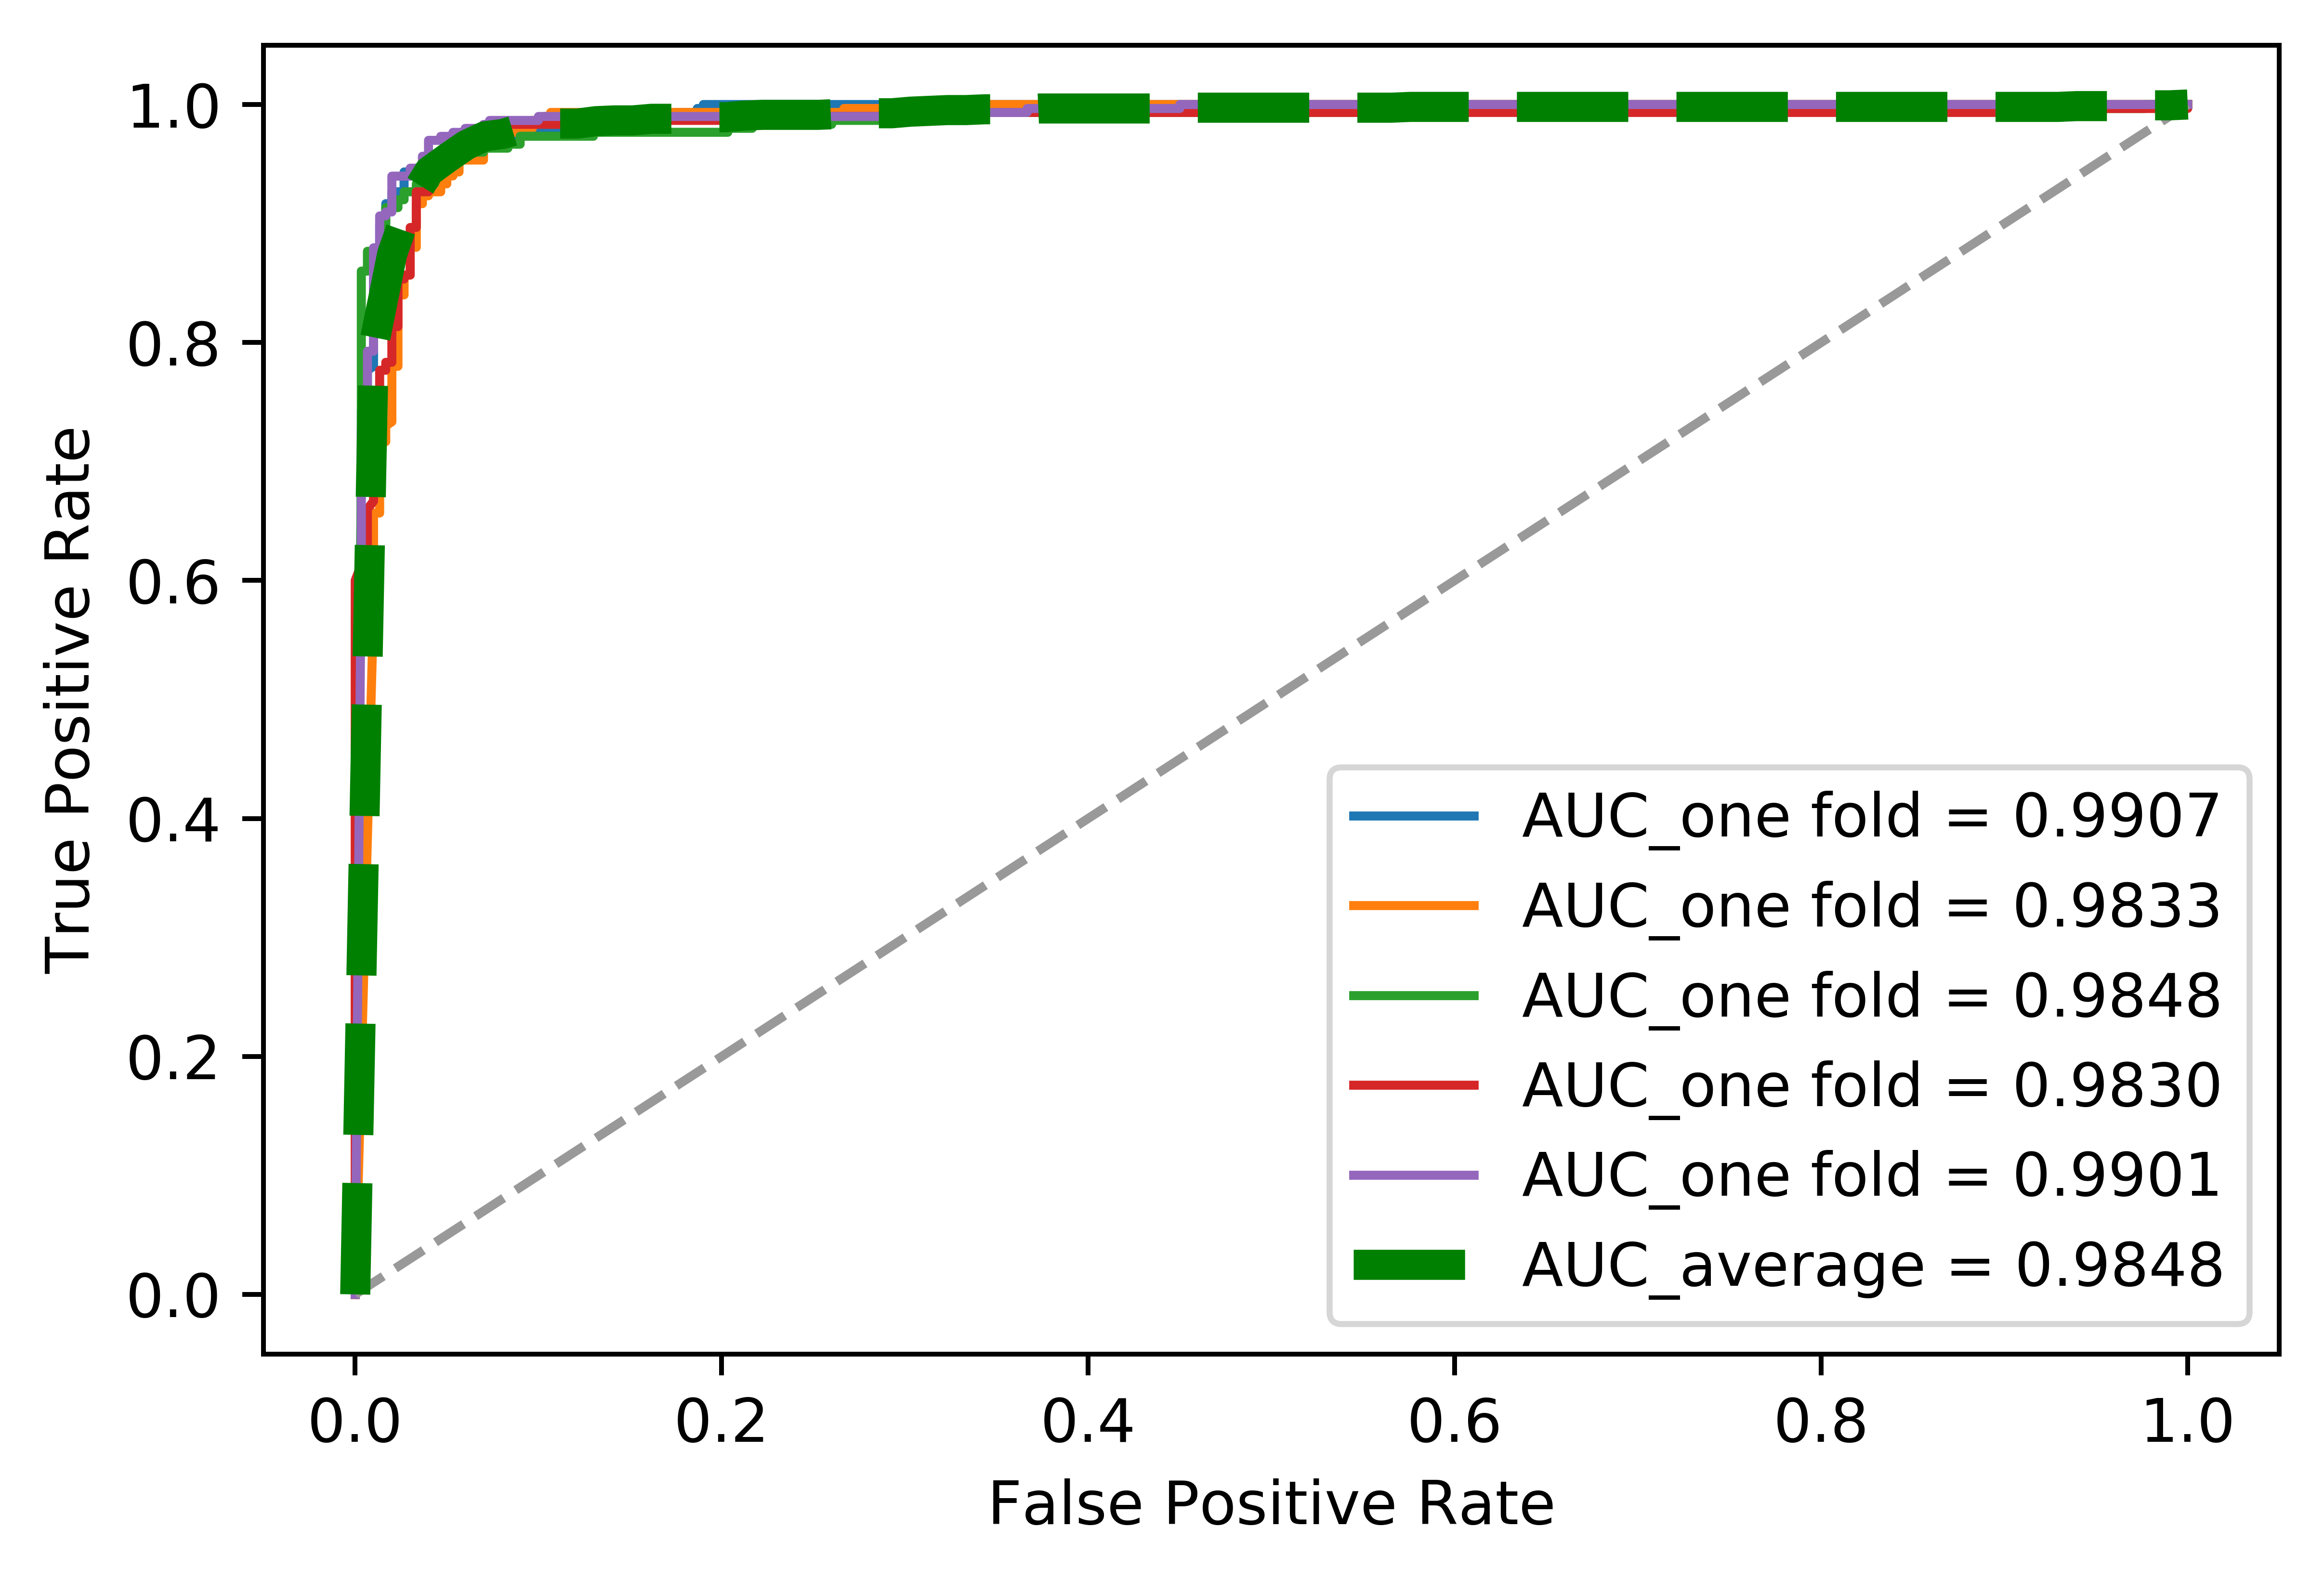

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import shuffle
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

inputfile = 'C:/Users/wang/Desktop/Training_set_AAC_features.csv'
labels = ['positive', 'negative']
tick_marks = np.array(range(len(labels))) + 0.5

def readData():

    data = pd.read_csv(inputfile, encoding='utf8')
    data = data.values.astype(np.float32)
    shuffle(data)  # 随机打乱
    data_train = data[:int(1 * len(data)), :]  # 数据集矩阵
    return data_train


def train(data_train):

    x = data_train[:, 1:19] * 30  # 从第二维到最后
    y = data_train[:, 20].astype(int)  # 第一维
    return x, y


if __name__ == '__main__':
    data_train = readData()
    x, y = train(data_train)



#smo = SMOTE(random_state=42)
#x_train, y_train = smo.fit_resample(x_train, y_train)
#print(Counter(y_train))

# 画平均ROC曲线的两个参数
clf1 = MLPClassifier(
    hidden_layer_sizes=(100,50),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

clf2  = MLPClassifier(
    hidden_layer_sizes=(100,100,50,25),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

clf3 = MLPClassifier(
    hidden_layer_sizes=(100,100,50,25),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

clf4 = MLPClassifier(
    hidden_layer_sizes=(100,50),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

model = VotingClassifier(estimators=[('dnn1', clf1), ('dnn2', clf2), ('dnn3', clf3), ('dnn4', clf4)], voting='soft', weights=[1, 2, 2, 1])

smo = SMOTE(random_state=42)
cv = StratifiedKFold(n_splits=5)  # 导入该模型，后面将数据划分5份

mean_tpr = 0.0  # 用来记录画平均ROC曲线的信息
mean_fpr = np.linspace(0, 1, 100)
cnt = 0
for i, (train, test) in enumerate(cv.split(x, y)):  # 利用模型划分数据集和目标变量 为一一对应的下标
    cnt += 1

    x_train, y_train = smo.fit_resample(x[train], y[train])
    print(Counter(y_train))
    probas_ = model.fit(x_train, y_train).predict_proba(x[test])  # 训练模型后预测每条样本得到两种结果的概率
    #print(probas_)
    y_pred = model.predict(x[test])
    #print(y_pred)
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])  # 该函数得到伪正例、真正例、阈值，这里只使用前两个
    mean_tpr += np.interp(mean_fpr, fpr, tpr)  # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0  # 将第一个真正例=0 以0为起点
    roc_auc = auc(fpr, tpr)  # 求auc面积


    plt.plot(fpr, tpr,  label='AUC_one fold = {0:.4f}'.format(roc_auc), lw=1.5)  # 画出当前分割数据的ROC曲线


    accuracy = accuracy_score(y[test], y_pred)
    print("accuracy: %.2f%%" % (accuracy * 100.0))

    recall = recall_score(y[test], y_pred)
    print("recall: %.2f%%" % (recall * 100.0))

    prec = precision_score(y[test], y_pred)
    print("prec: %.2f%%" % (prec * 100.0))

    f1 = f1_score(y[test], y_pred)
    print("f1: %.2f%%" % (f1 * 100.0))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))  # 画对角线

mean_tpr /= cnt  # 求数组的平均值
mean_tpr[-1] = 1.0  # 坐标最后一个点为（1,1）  以1为终点
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'g--', label='AUC_average = {0:.4f}'.format(mean_auc), lw=5)

plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
#plt.title('model')
plt.legend(loc="lower right")
plt.savefig('Voting算法Training_set的AAC特征ROC曲线.jpg')
plt.rcParams['figure.dpi'] = 900 # 设置全局dpi值为900，根据需要进行调整
plt.show()

# Training PseAAC

Counter({1: 1200, 0: 1200})
accuracy: 87.33%
recall: 94.00%
prec: 82.94%
f1: 88.12%
Counter({1: 1200, 0: 1200})
accuracy: 87.17%
recall: 93.00%
prec: 83.28%
f1: 87.87%
Counter({1: 1200, 0: 1200})
accuracy: 87.67%
recall: 93.33%
prec: 83.83%
f1: 88.33%
Counter({1: 1200, 0: 1200})
accuracy: 87.17%
recall: 91.33%
prec: 84.31%
f1: 87.68%
Counter({1: 1200, 0: 1200})
accuracy: 88.81%
recall: 93.98%
prec: 85.15%
f1: 89.35%


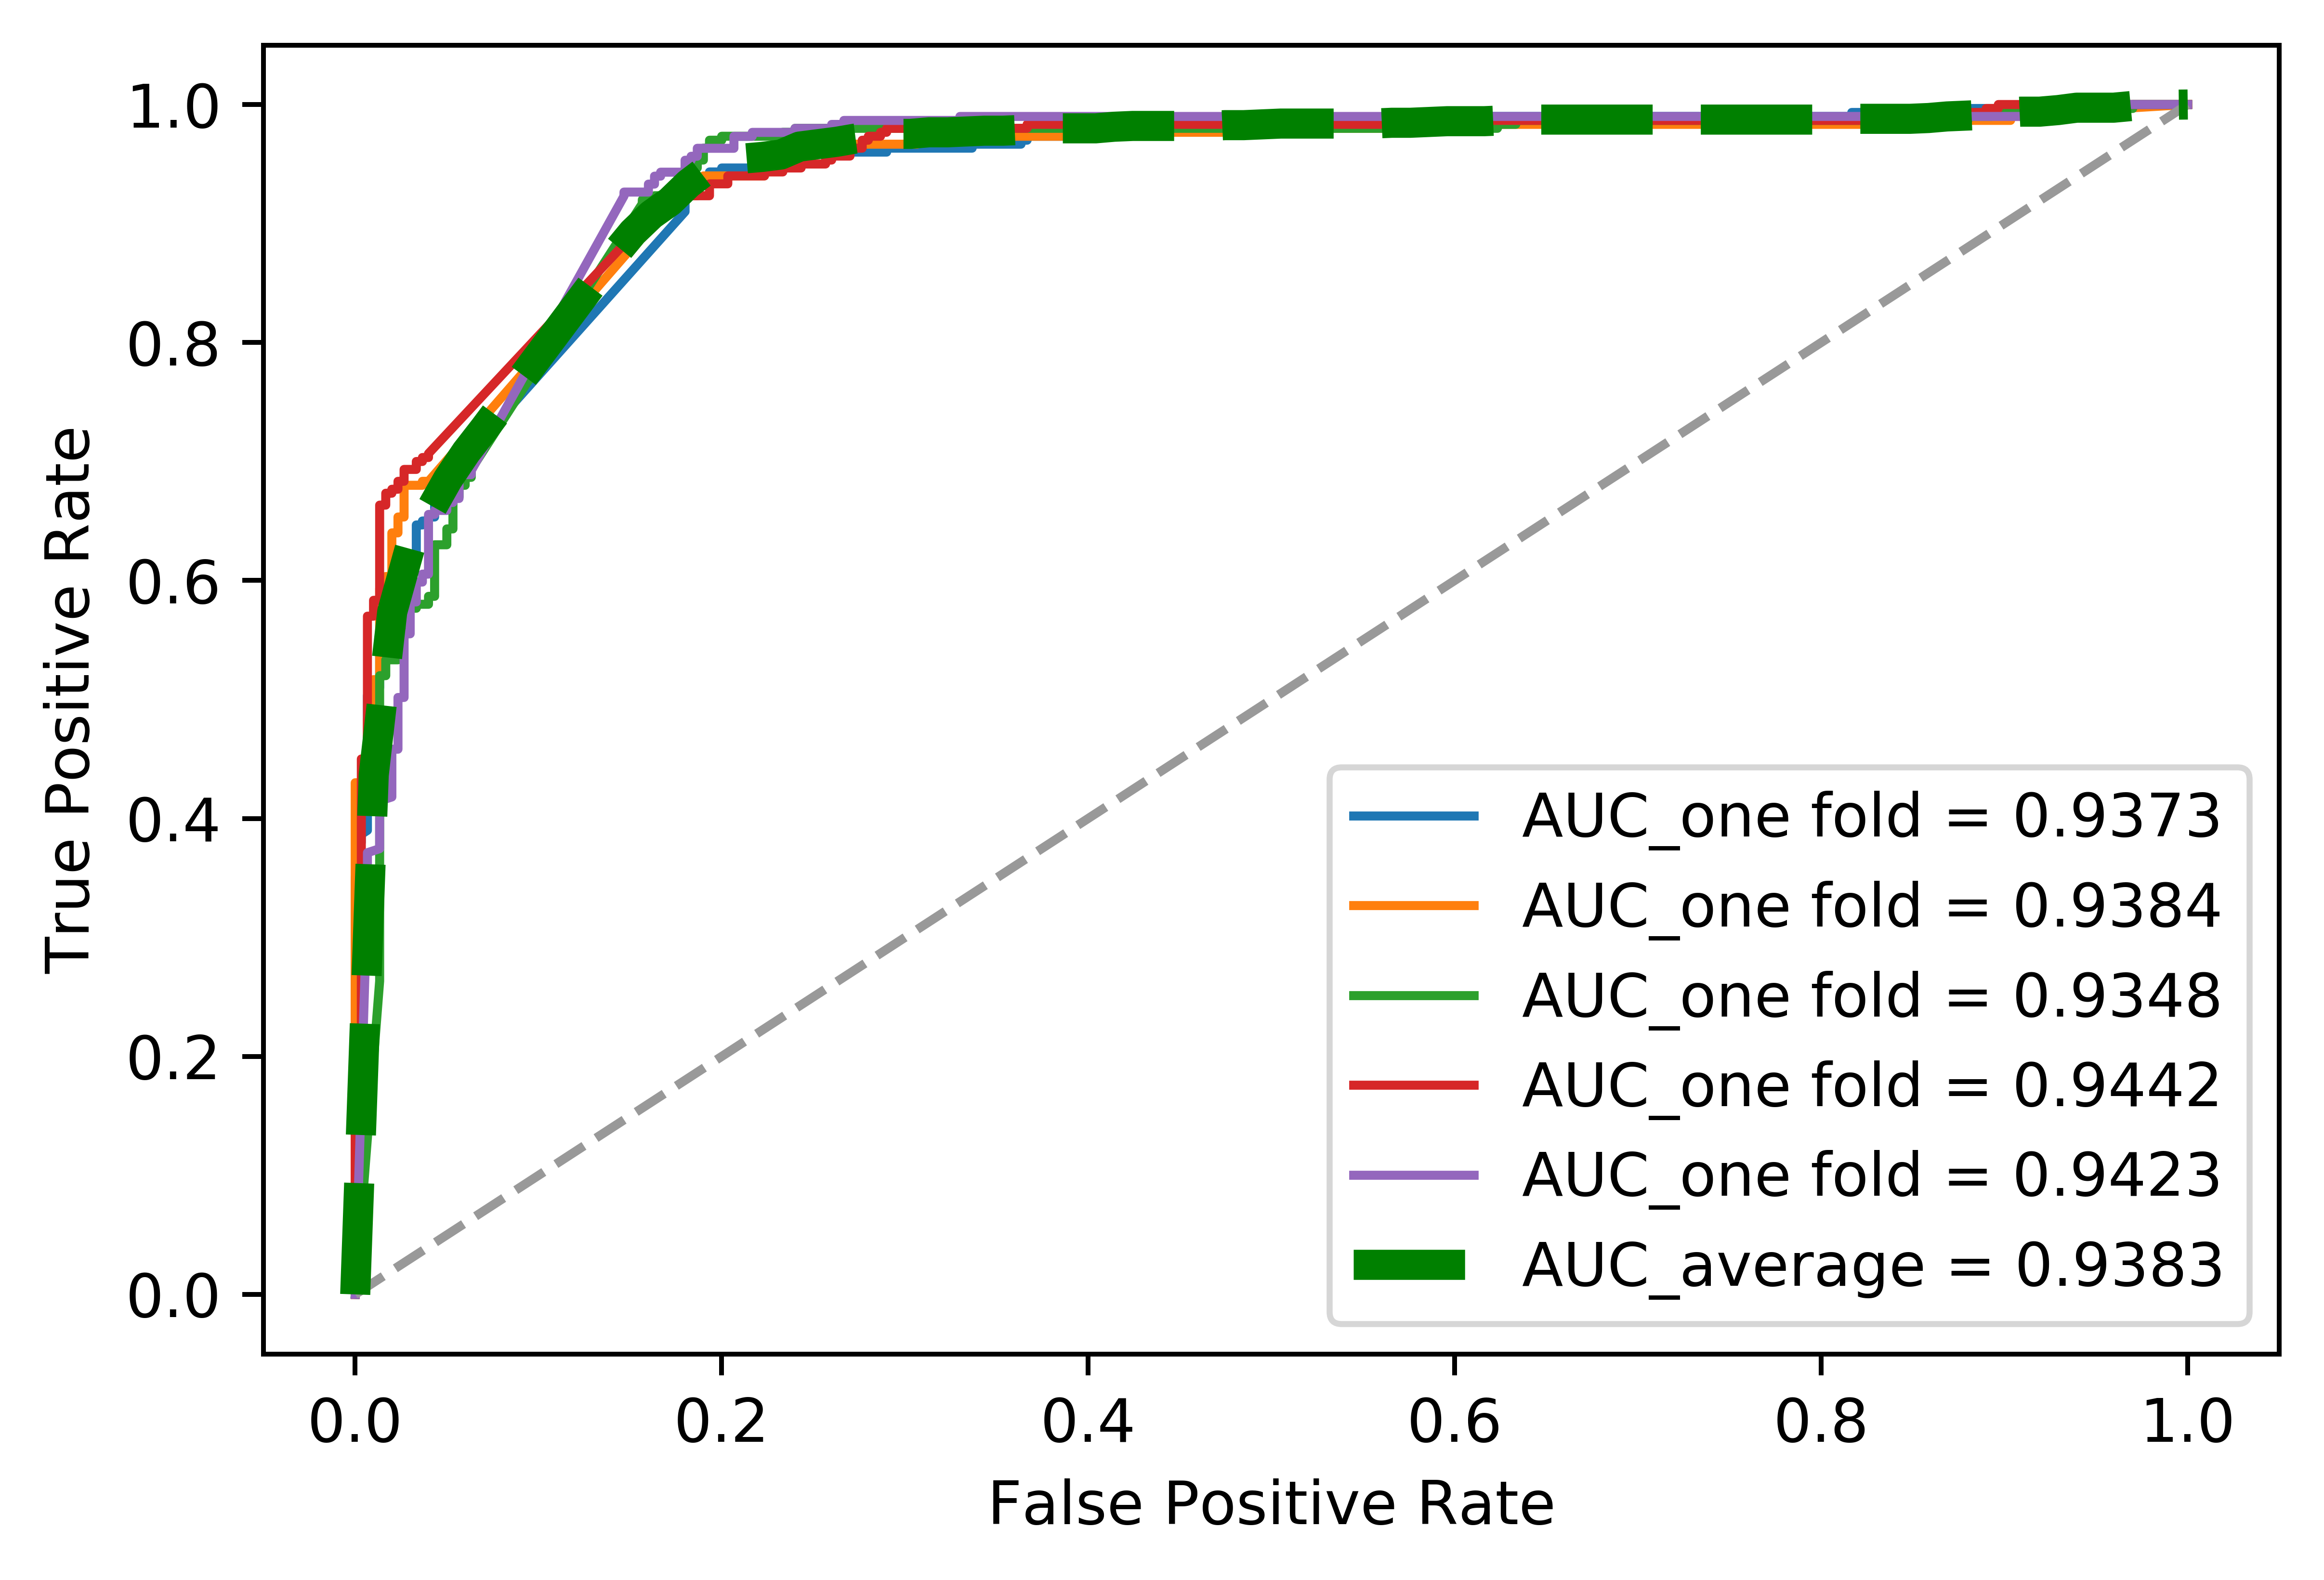

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import shuffle
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

inputfile = 'C:/Users/wang/Desktop/Training_set_PseAAC_features.csv'
labels = ['positive', 'negative']
tick_marks = np.array(range(len(labels))) + 0.5

def readData():

    data = pd.read_csv(inputfile, encoding='utf8')
    data = data.values.astype(np.float32)
    shuffle(data)  # 随机打乱
    data_train = data[:int(1 * len(data)), :]  # 数据集矩阵
    return data_train


def train(data_train):

    x = data_train[:, 1:19] * 30  # 从第二维到最后
    y = data_train[:, 20].astype(int)  # 第一维
    return x, y


if __name__ == '__main__':
    data_train = readData()
    x, y = train(data_train)



#smo = SMOTE(random_state=42)
#x_train, y_train = smo.fit_resample(x_train, y_train)
#print(Counter(y_train))

# 画平均ROC曲线的两个参数
clf1 = MLPClassifier(
    hidden_layer_sizes=(100,50),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

clf2  = MLPClassifier(
    hidden_layer_sizes=(100,100,50,25),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

clf3 = MLPClassifier(
    hidden_layer_sizes=(100,100,50,25),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

clf4 = MLPClassifier(
    hidden_layer_sizes=(100,50),
    random_state = 420,
    max_iter = 5000,
   learning_rate_init = 0.001,
    momentum = 0.9,
    batch_size = 8,
    solver = "adam",
    activation = "relu"
) # 使用两层，每层50个节点

model = VotingClassifier(estimators=[('dnn1', clf1), ('dnn2', clf2), ('dnn3', clf3), ('dnn4', clf4)], voting='soft', weights=[1, 2, 2, 1])

smo = SMOTE(random_state=42)
cv = StratifiedKFold(n_splits=5)  # 导入该模型，后面将数据划分5份

mean_tpr = 0.0  # 用来记录画平均ROC曲线的信息
mean_fpr = np.linspace(0, 1, 100)
cnt = 0
for i, (train, test) in enumerate(cv.split(x, y)):  # 利用模型划分数据集和目标变量 为一一对应的下标
    cnt += 1

    x_train, y_train = smo.fit_resample(x[train], y[train])
    print(Counter(y_train))
    probas_ = model.fit(x_train, y_train).predict_proba(x[test])  # 训练模型后预测每条样本得到两种结果的概率
    #print(probas_)
    y_pred = model.predict(x[test])
    #print(y_pred)
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])  # 该函数得到伪正例、真正例、阈值，这里只使用前两个
    mean_tpr += np.interp(mean_fpr, fpr, tpr)  # 插值函数 interp(x坐标,每次x增加距离,y坐标)  累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0  # 将第一个真正例=0 以0为起点
    roc_auc = auc(fpr, tpr)  # 求auc面积


    plt.plot(fpr, tpr,  label='AUC_one fold = {0:.4f}'.format(roc_auc), lw=1.5)  # 画出当前分割数据的ROC曲线


    accuracy = accuracy_score(y[test], y_pred)
    print("accuracy: %.2f%%" % (accuracy * 100.0))

    recall = recall_score(y[test], y_pred)
    print("recall: %.2f%%" % (recall * 100.0))

    prec = precision_score(y[test], y_pred)
    print("prec: %.2f%%" % (prec * 100.0))

    f1 = f1_score(y[test], y_pred)
    print("f1: %.2f%%" % (f1 * 100.0))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))  # 画对角线

mean_tpr /= cnt  # 求数组的平均值
mean_tpr[-1] = 1.0  # 坐标最后一个点为（1,1）  以1为终点
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'g--', label='AUC_average = {0:.4f}'.format(mean_auc), lw=5)

plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
#plt.title('model')
plt.legend(loc="lower right")
plt.savefig('Voting算法Training_set的PseAAC特征ROC曲线.jpg')
plt.rcParams['figure.dpi'] = 900 # 设置全局dpi值为900，根据需要进行调整
plt.show()

# Test AAC

Counter({1: 202, 0: 202})
Counter({0: 176, 1: 176})


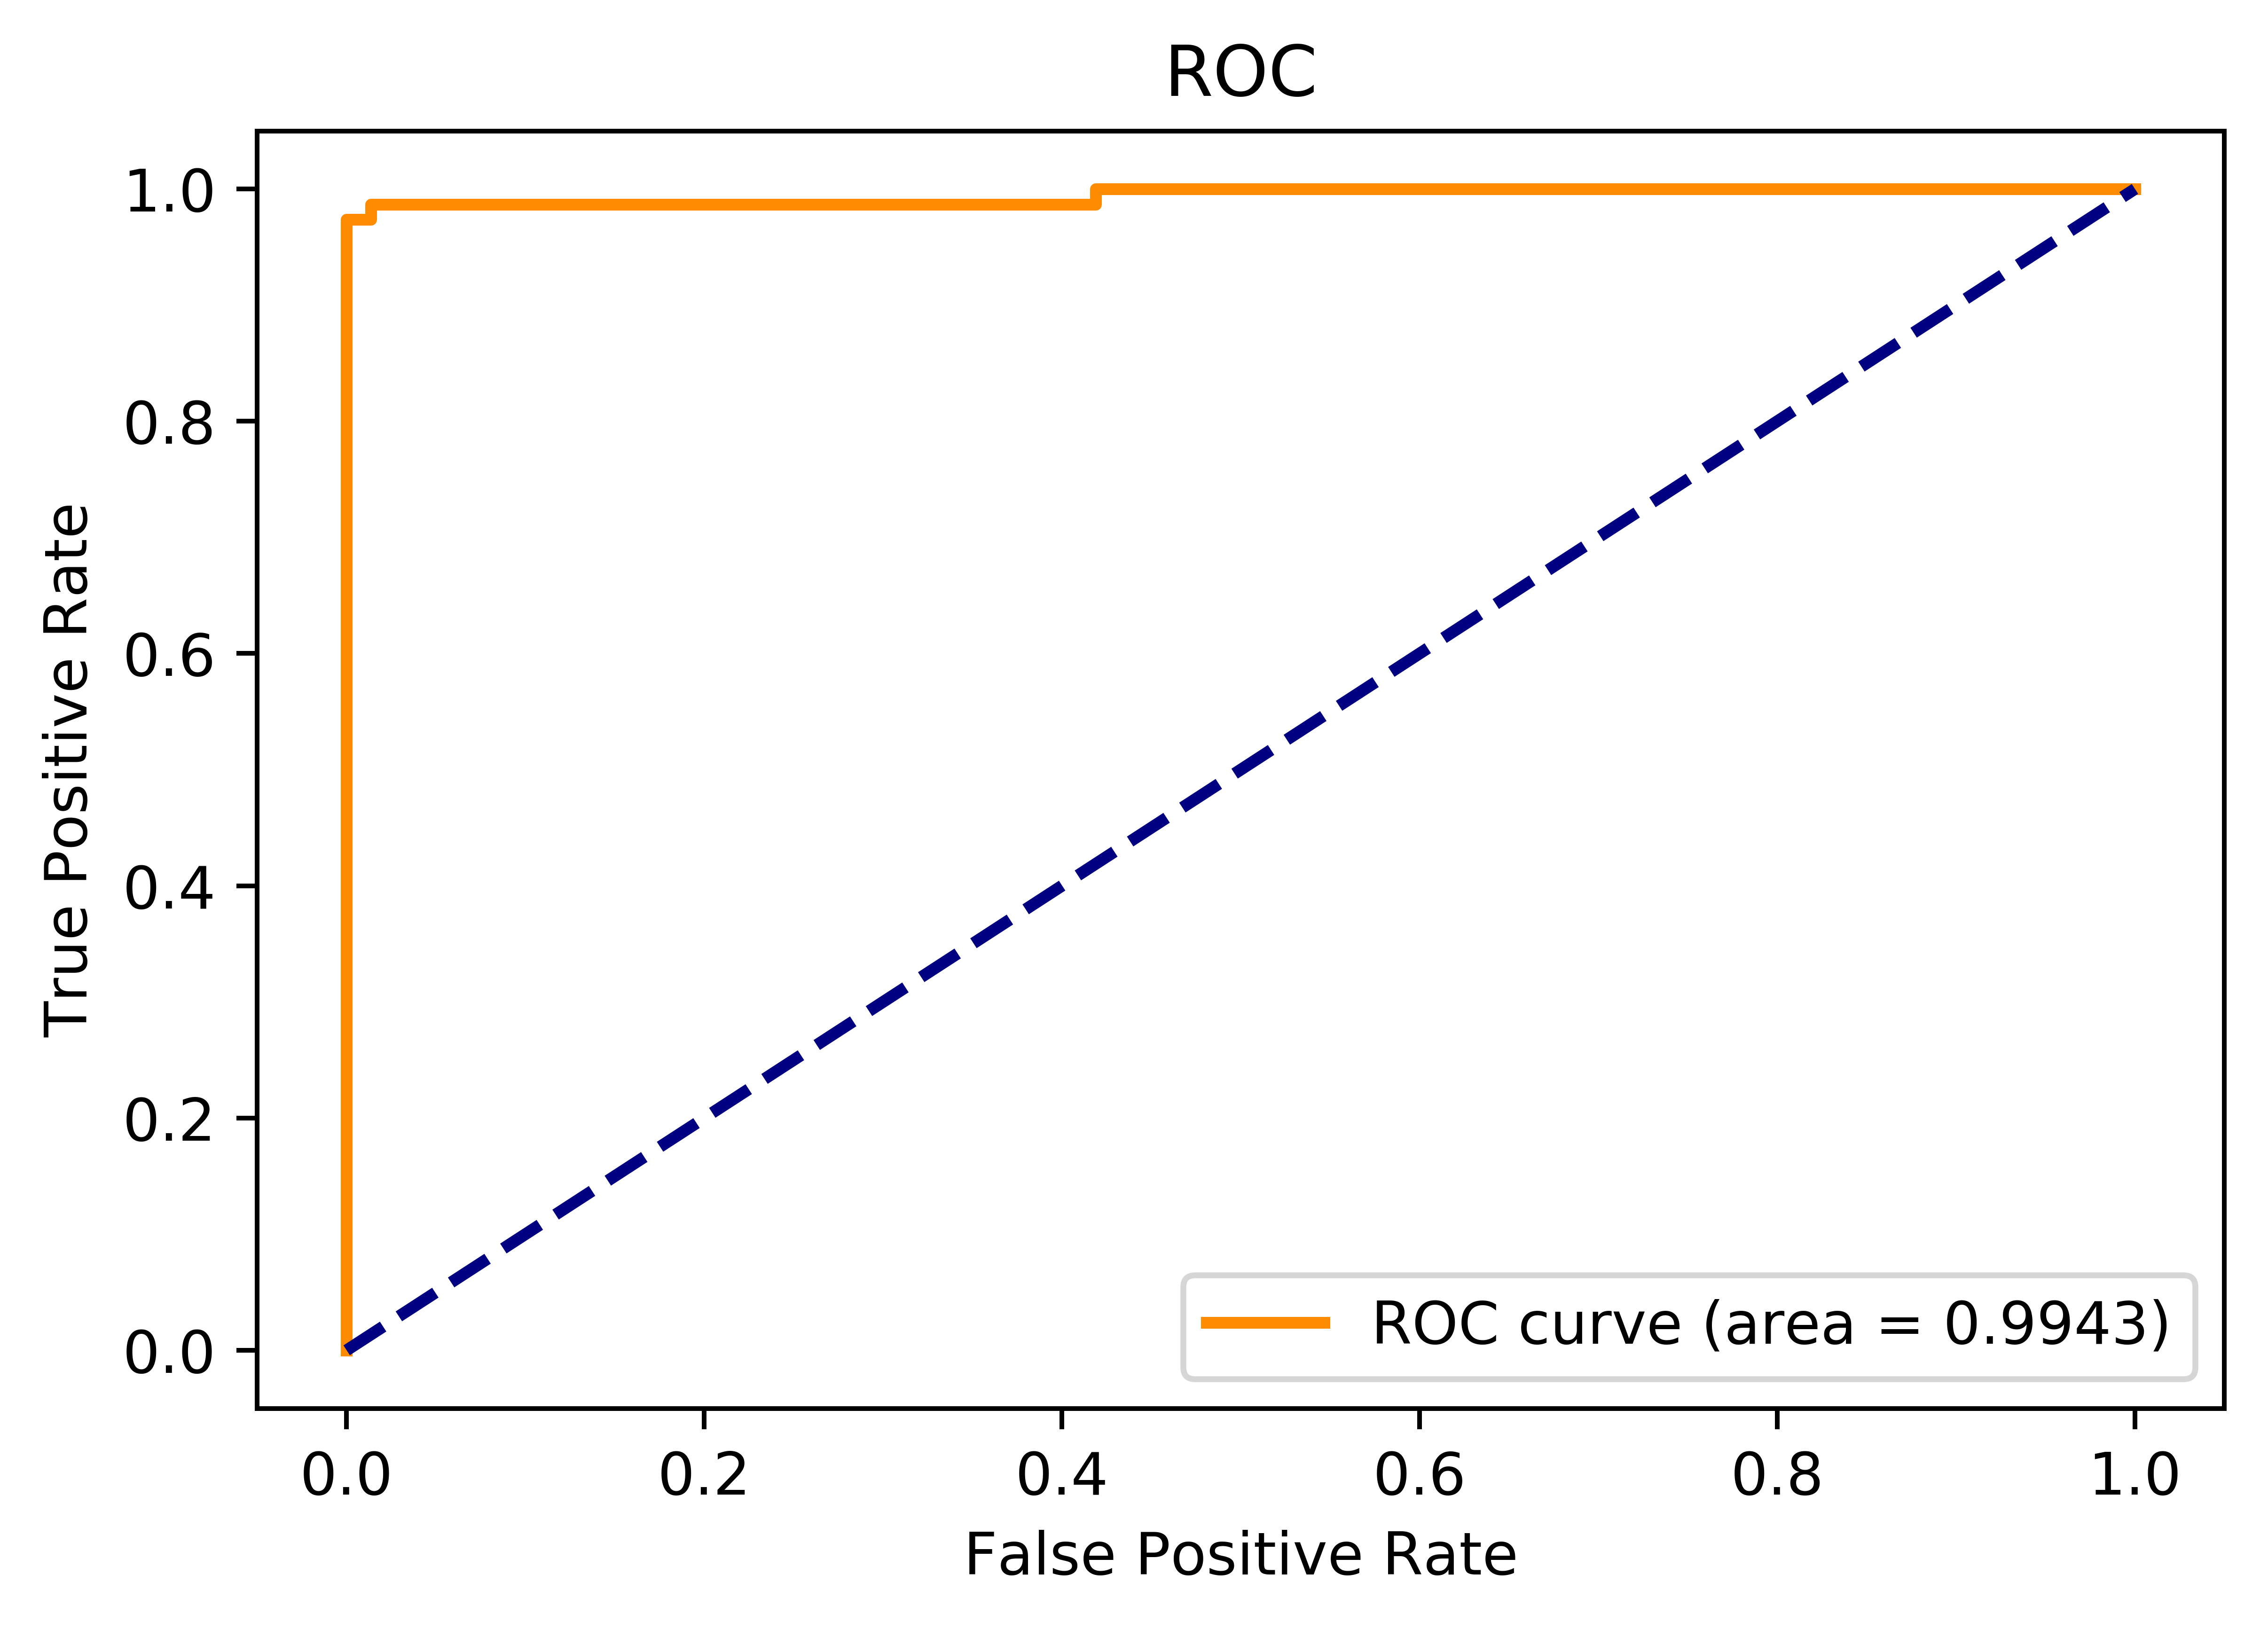

accuracy: 97.33%
recall: 98.68%
prec: 96.15%
f1: 97.40%


In [122]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import shuffle
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

inputfile = 'C:/Users/wang/Desktop/Test_set_AAC_features.csv'
labels = ['positive', 'negative']
tick_marks = np.array(range(len(labels))) + 0.5

def readData():

    data = pd.read_csv(inputfile, encoding='utf8')
    data = data.values.astype(np.float32)
    shuffle(data)  # 随机打乱
    data_train = data[:int(1 * len(data)), :]  # 数据集矩阵
    return data_train


def train(data_train):

    x = data_train[:, 1:19] * 30  # 从第二维到最后
    y = data_train[:, 20].astype(int)  # 第一维
    return x, y


if __name__ == '__main__':
    data_train = readData()
    x, y = train(data_train)

    # 数据集划分
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # 进行SMOTE过采样
    smo = SMOTE(random_state=42)
    x_train, y_train = smo.fit_resample(x_train, y_train)
    print(Counter(y_train))

    # 画平均ROC曲线的两个参数
    clf1 = MLPClassifier(
        hidden_layer_sizes=(100,50),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点

    clf2  = MLPClassifier(
        hidden_layer_sizes=(100,100,50,25),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点

    clf3 = MLPClassifier(
        hidden_layer_sizes=(100,100,50,25),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点

    clf4 = MLPClassifier(
        hidden_layer_sizes=(100,50),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点
model = VotingClassifier(estimators=[('dnn1', clf1), ('dnn2', clf2), ('dnn3', clf3), ('dnn4', clf4)], voting='soft', weights=[1, 2, 2, 1])
smo = SMOTE(random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, y_train = smo.fit_resample(x_train, y_train)
print(Counter(y_train))
probas_ = model.fit(x_train, y_train).predict_proba(x_test) # 训练模型后预测每条样本得到两种结果的概率
y_pred = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) # 该函数得到伪正例、真正例、阈值，这里只使用前两个
roc_auc = auc(fpr, tpr) # 求auc面积
#画ROC曲线

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Voting算法Test_set的AAC特征ROC曲线.jpg')
plt.rcParams['figure.dpi'] = 900 # 设置全局dpi值为900，根据需要进行调整
plt.show()
#输出评估结果
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y_test, y_pred)
print("recall: %.2f%%" % (recall * 100.0))

prec = precision_score(y_test, y_pred)
print("prec: %.2f%%" % (prec * 100.0))

f1 = f1_score(y_test, y_pred)
print("f1: %.2f%%" % (f1 * 100.0))

# Test PseAAC

Counter({1: 207, 0: 207})
Counter({0: 180, 1: 180})


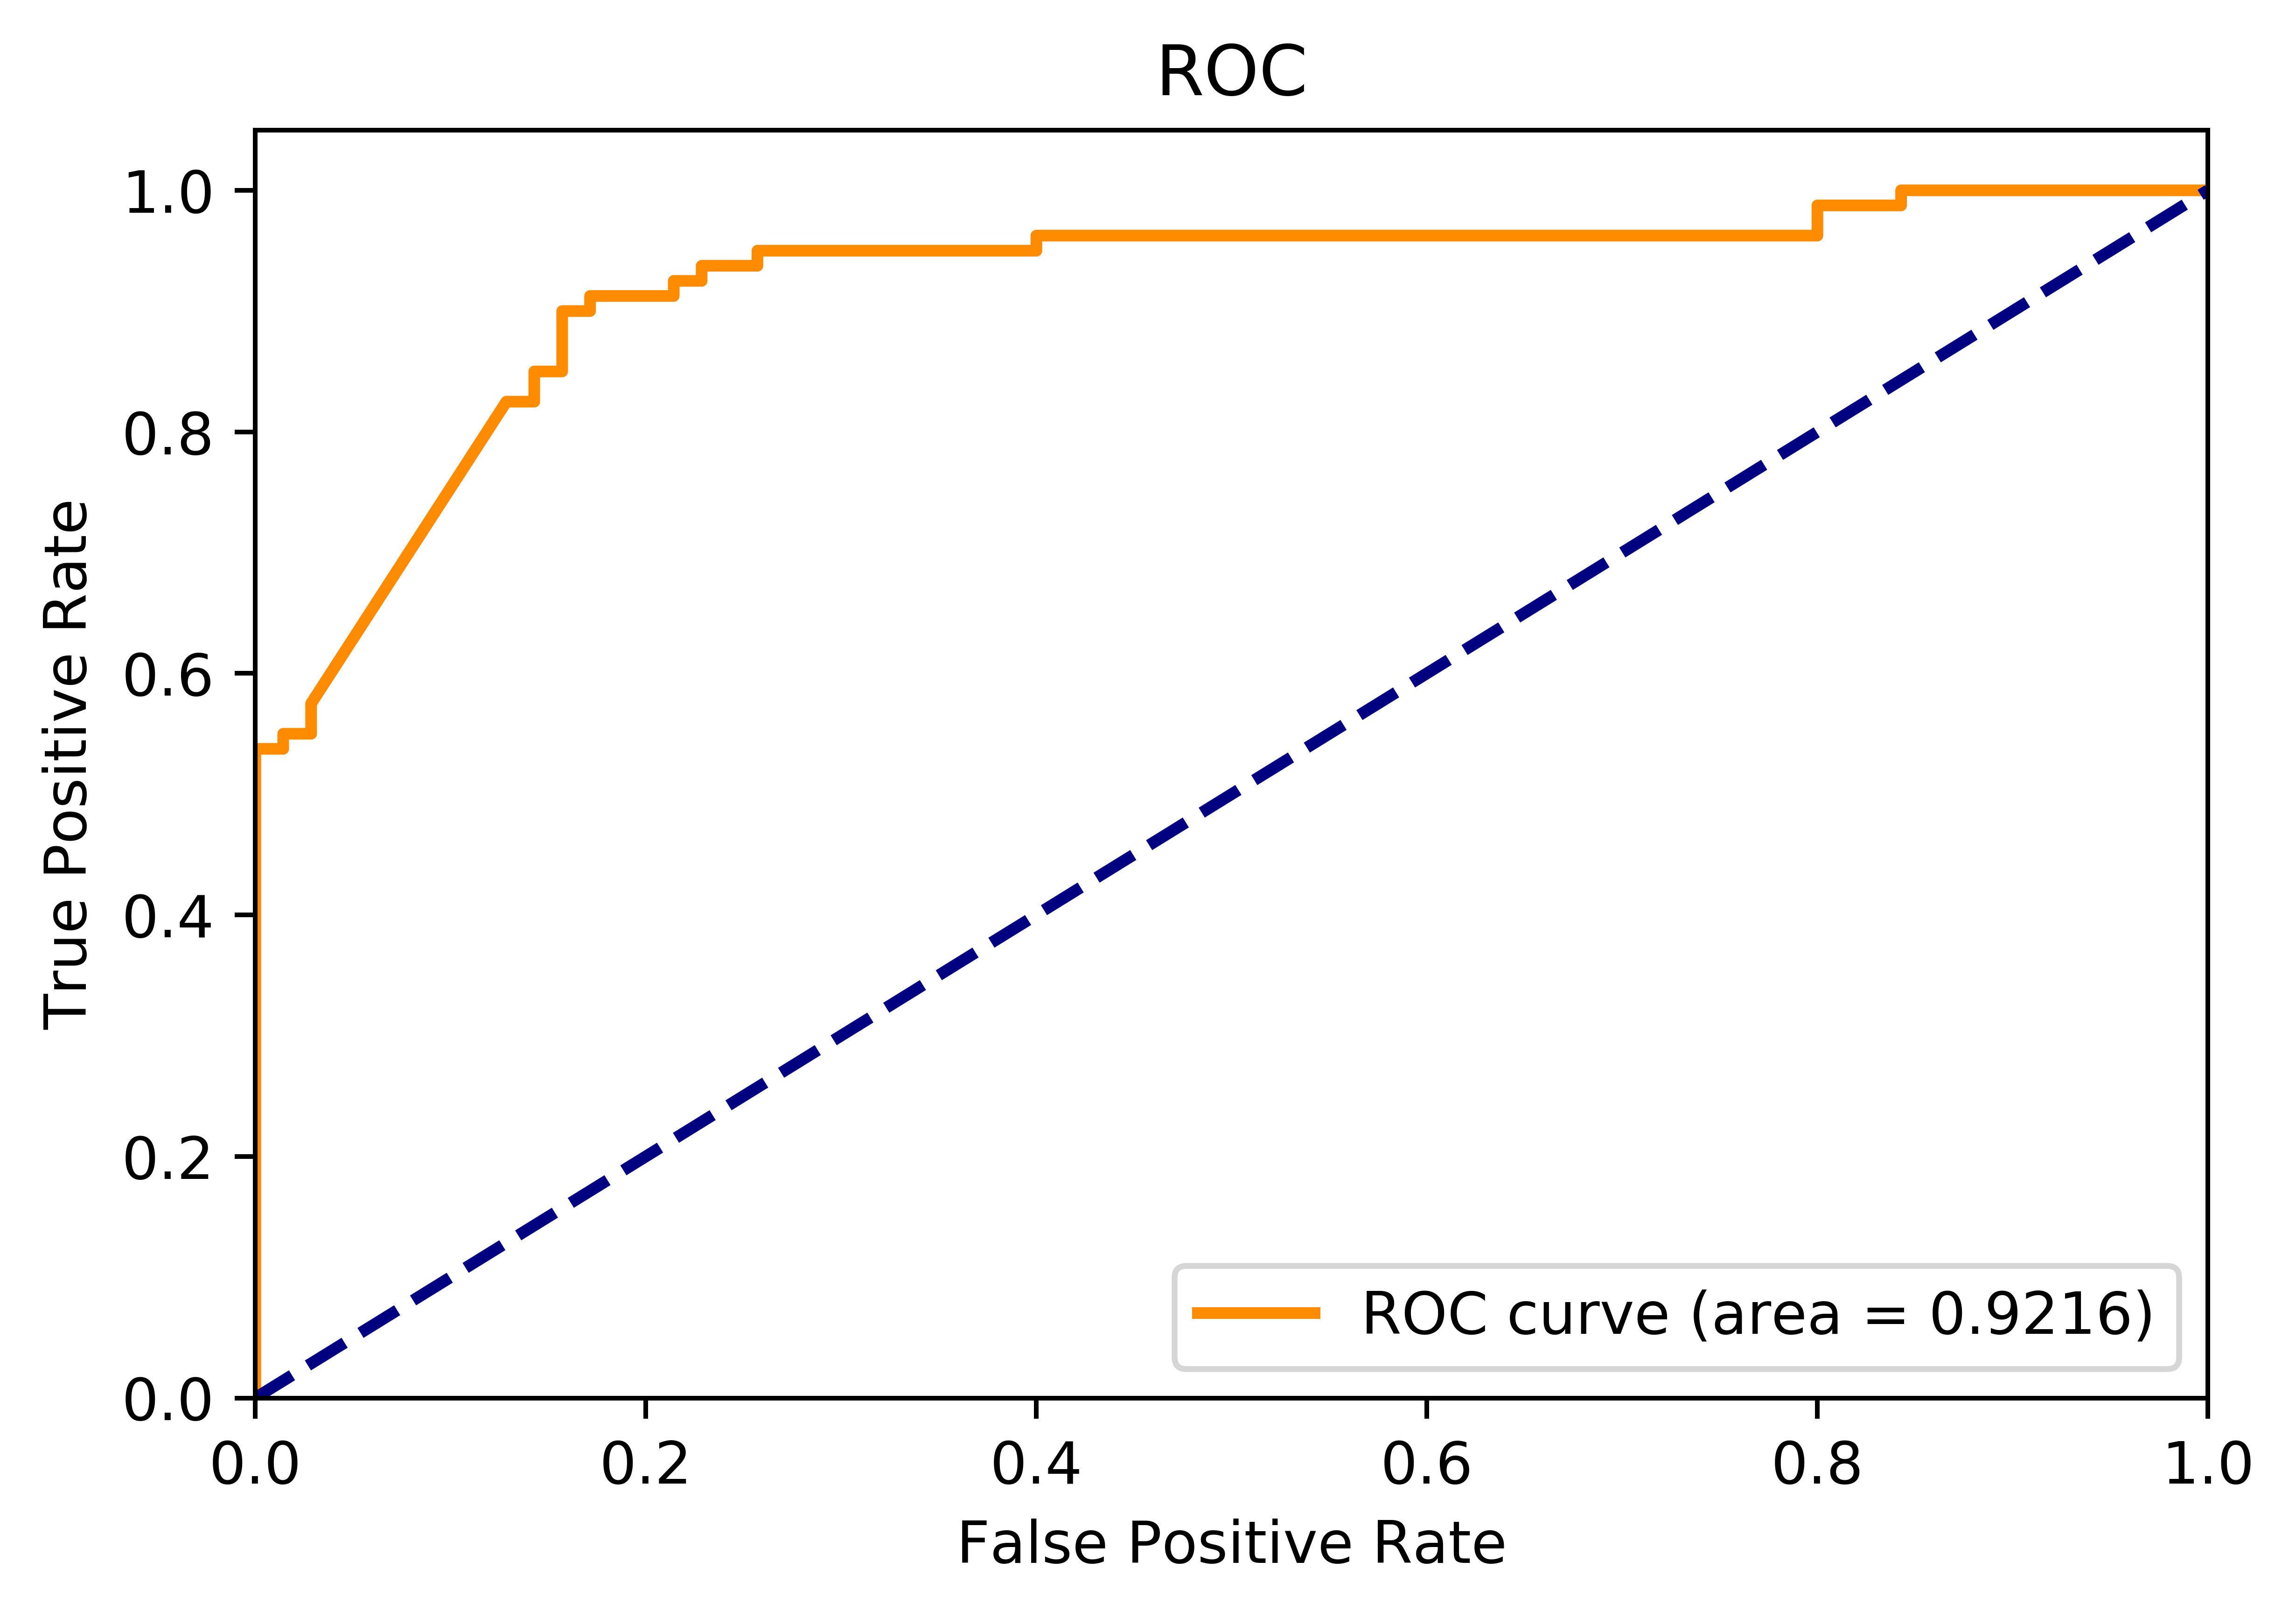

accuracy: 76.00%
recall: 57.50%
prec: 95.83%
f1: 71.88%


In [148]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import shuffle
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

inputfile = 'C:/Users/wang/Desktop/Test_set_PseAAC_features.csv'
labels = ['positive', 'negative']
tick_marks = np.array(range(len(labels))) + 0.5

def readData():

    data = pd.read_csv(inputfile, encoding='utf8')
    data = data.values.astype(np.float32)
    shuffle(data)  # 随机打乱
    data_train = data[:int(1 * len(data)), :]  # 数据集矩阵
    return data_train


def train(data_train):

    x = data_train[:, 1:19] * 30  # 从第二维到最后
    y = data_train[:, 20].astype(int)  # 第一维
    return x, y


if __name__ == '__main__':
    data_train = readData()
    x, y = train(data_train)

    # 数据集划分
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # 进行SMOTE过采样
    smo = SMOTE(random_state=42)
    x_train, y_train = smo.fit_resample(x_train, y_train)
    print(Counter(y_train))

    # 画平均ROC曲线的两个参数
    clf1 = MLPClassifier(
        hidden_layer_sizes=(100,50),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点

    clf2  = MLPClassifier(
        hidden_layer_sizes=(100,100,50,25),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点

    clf3 = MLPClassifier(
        hidden_layer_sizes=(100,100,50,25),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点

    clf4 = MLPClassifier(
        hidden_layer_sizes=(100,50),
        random_state = 420,
        max_iter = 5000,
        learning_rate_init = 0.001,
        momentum = 0.9,
        batch_size = 8,
        solver = "adam",
        activation = "relu"
    ) # 使用两层，每层50个节点
model = VotingClassifier(estimators=[('dnn1', clf1), ('dnn2', clf2), ('dnn3', clf3), ('dnn4', clf4)], voting='soft', weights=[1, 2, 2, 1])
smo = SMOTE(random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, y_train = smo.fit_resample(x_train, y_train)
print(Counter(y_train))
probas_ = model.fit(x_train, y_train).predict_proba(x_test) # 训练模型后预测每条样本得到两种结果的概率
y_pred = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) # 该函数得到伪正例、真正例、阈值，这里只使用前两个
roc_auc = auc(fpr, tpr) # 求auc面积
#画ROC曲线

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Voting算法Test_set的PseAAC特征ROC曲线.jpg')
plt.rcParams['figure.dpi'] = 900 # 设置全局dpi值为900，根据需要进行调整
plt.show()
#输出评估结果
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y_test, y_pred)
print("recall: %.2f%%" % (recall * 100.0))

prec = precision_score(y_test, y_pred)
print("prec: %.2f%%" % (prec * 100.0))

f1 = f1_score(y_test, y_pred)
print("f1: %.2f%%" % (f1 * 100.0))

# Test AAC（无SMOTE算法）

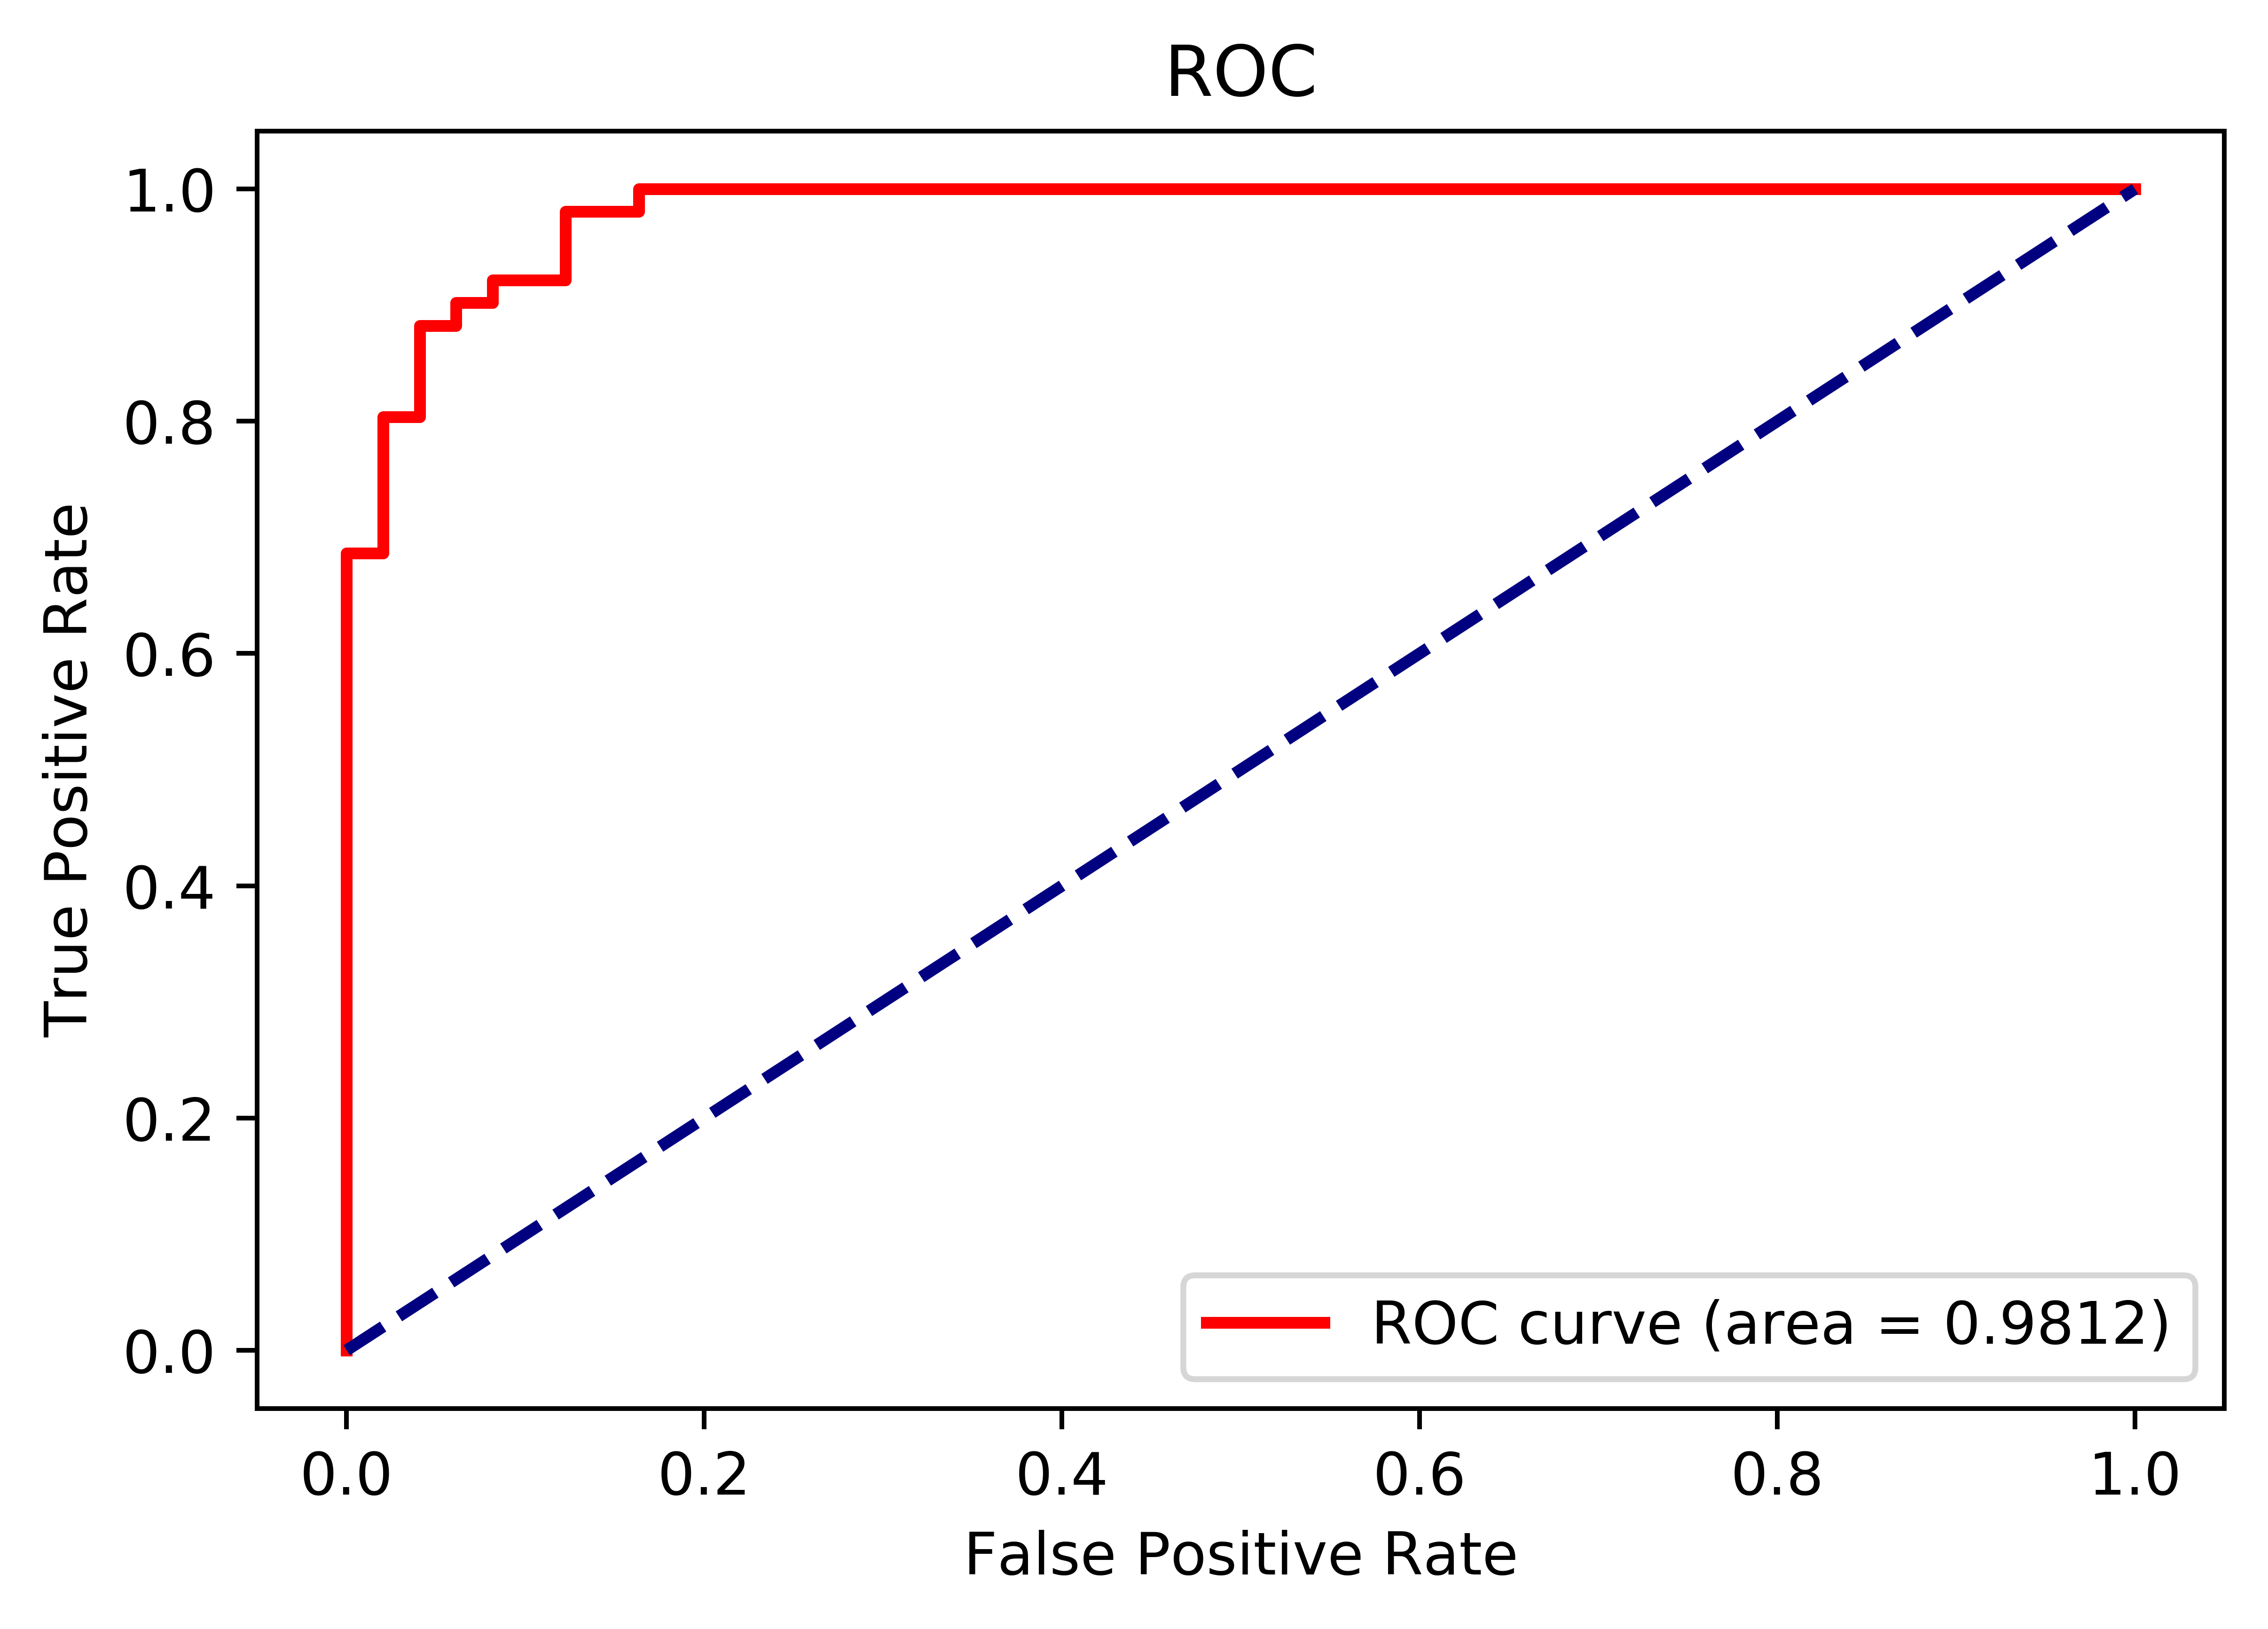

accuracy: 90.00%
recall: 92.16%
precision: 88.68%
f1: 90.38%


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import shuffle
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from collections import Counter

inputfile = 'C:/Users/wang/Desktop/Test_set_AAC_features.csv'
labels = ['positive', 'negative']
tick_marks = np.array(range(len(labels))) + 0.5

def readData():
    data = pd.read_csv(inputfile, encoding='utf8')
    data = data.values.astype(np.float32)
    shuffle(data)
    data_train = data[:int(1 * len(data)), :]
    return data_train

def train(data_train):
    x = data_train[:, 1:19] * 30
    y = data_train[:, 20].astype(int)
    return x, y

if __name__ == '__main__':
    data_train = readData()
    x, y = train(data_train)

    # 数据集划分
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # 定义多个MLP分类器
    clf1 = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    clf2 = MLPClassifier(
        hidden_layer_sizes=(100, 100, 50, 25),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    clf3 = MLPClassifier(
        hidden_layer_sizes=(100, 100, 50, 25),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    clf4 = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    # 使用投票分类器
    model = VotingClassifier(estimators=[('dnn1', clf1), ('dnn2', clf2), ('dnn3', clf3), ('dnn4', clf4)], voting='soft', weights=[1, 2, 2, 1])

    # 模型训练
    model.fit(x_train, y_train)

    # 模型预测
    probas_ = model.predict_proba(x_test)
    y_pred = model.predict(x_test)

    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)

    # 画ROC曲线
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig('Voting算法Test_set的AAC特征ROC曲线（无SMOTE算法）.jpg')
    plt.rcParams['figure.dpi'] = 900
    plt.show()

    # 输出评估结果
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: %.2f%%" % (accuracy * 100.0))

    recall = recall_score(y_test, y_pred)
    print("recall: %.2f%%" % (recall * 100.0))

    prec = precision_score(y_test, y_pred)
    print("precision: %.2f%%" % (prec * 100.0))

    f1 = f1_score(y_test, y_pred)
    print("f1: %.2f%%" % (f1 * 100.0))


# Test PseAAC（无SMOTE算法）

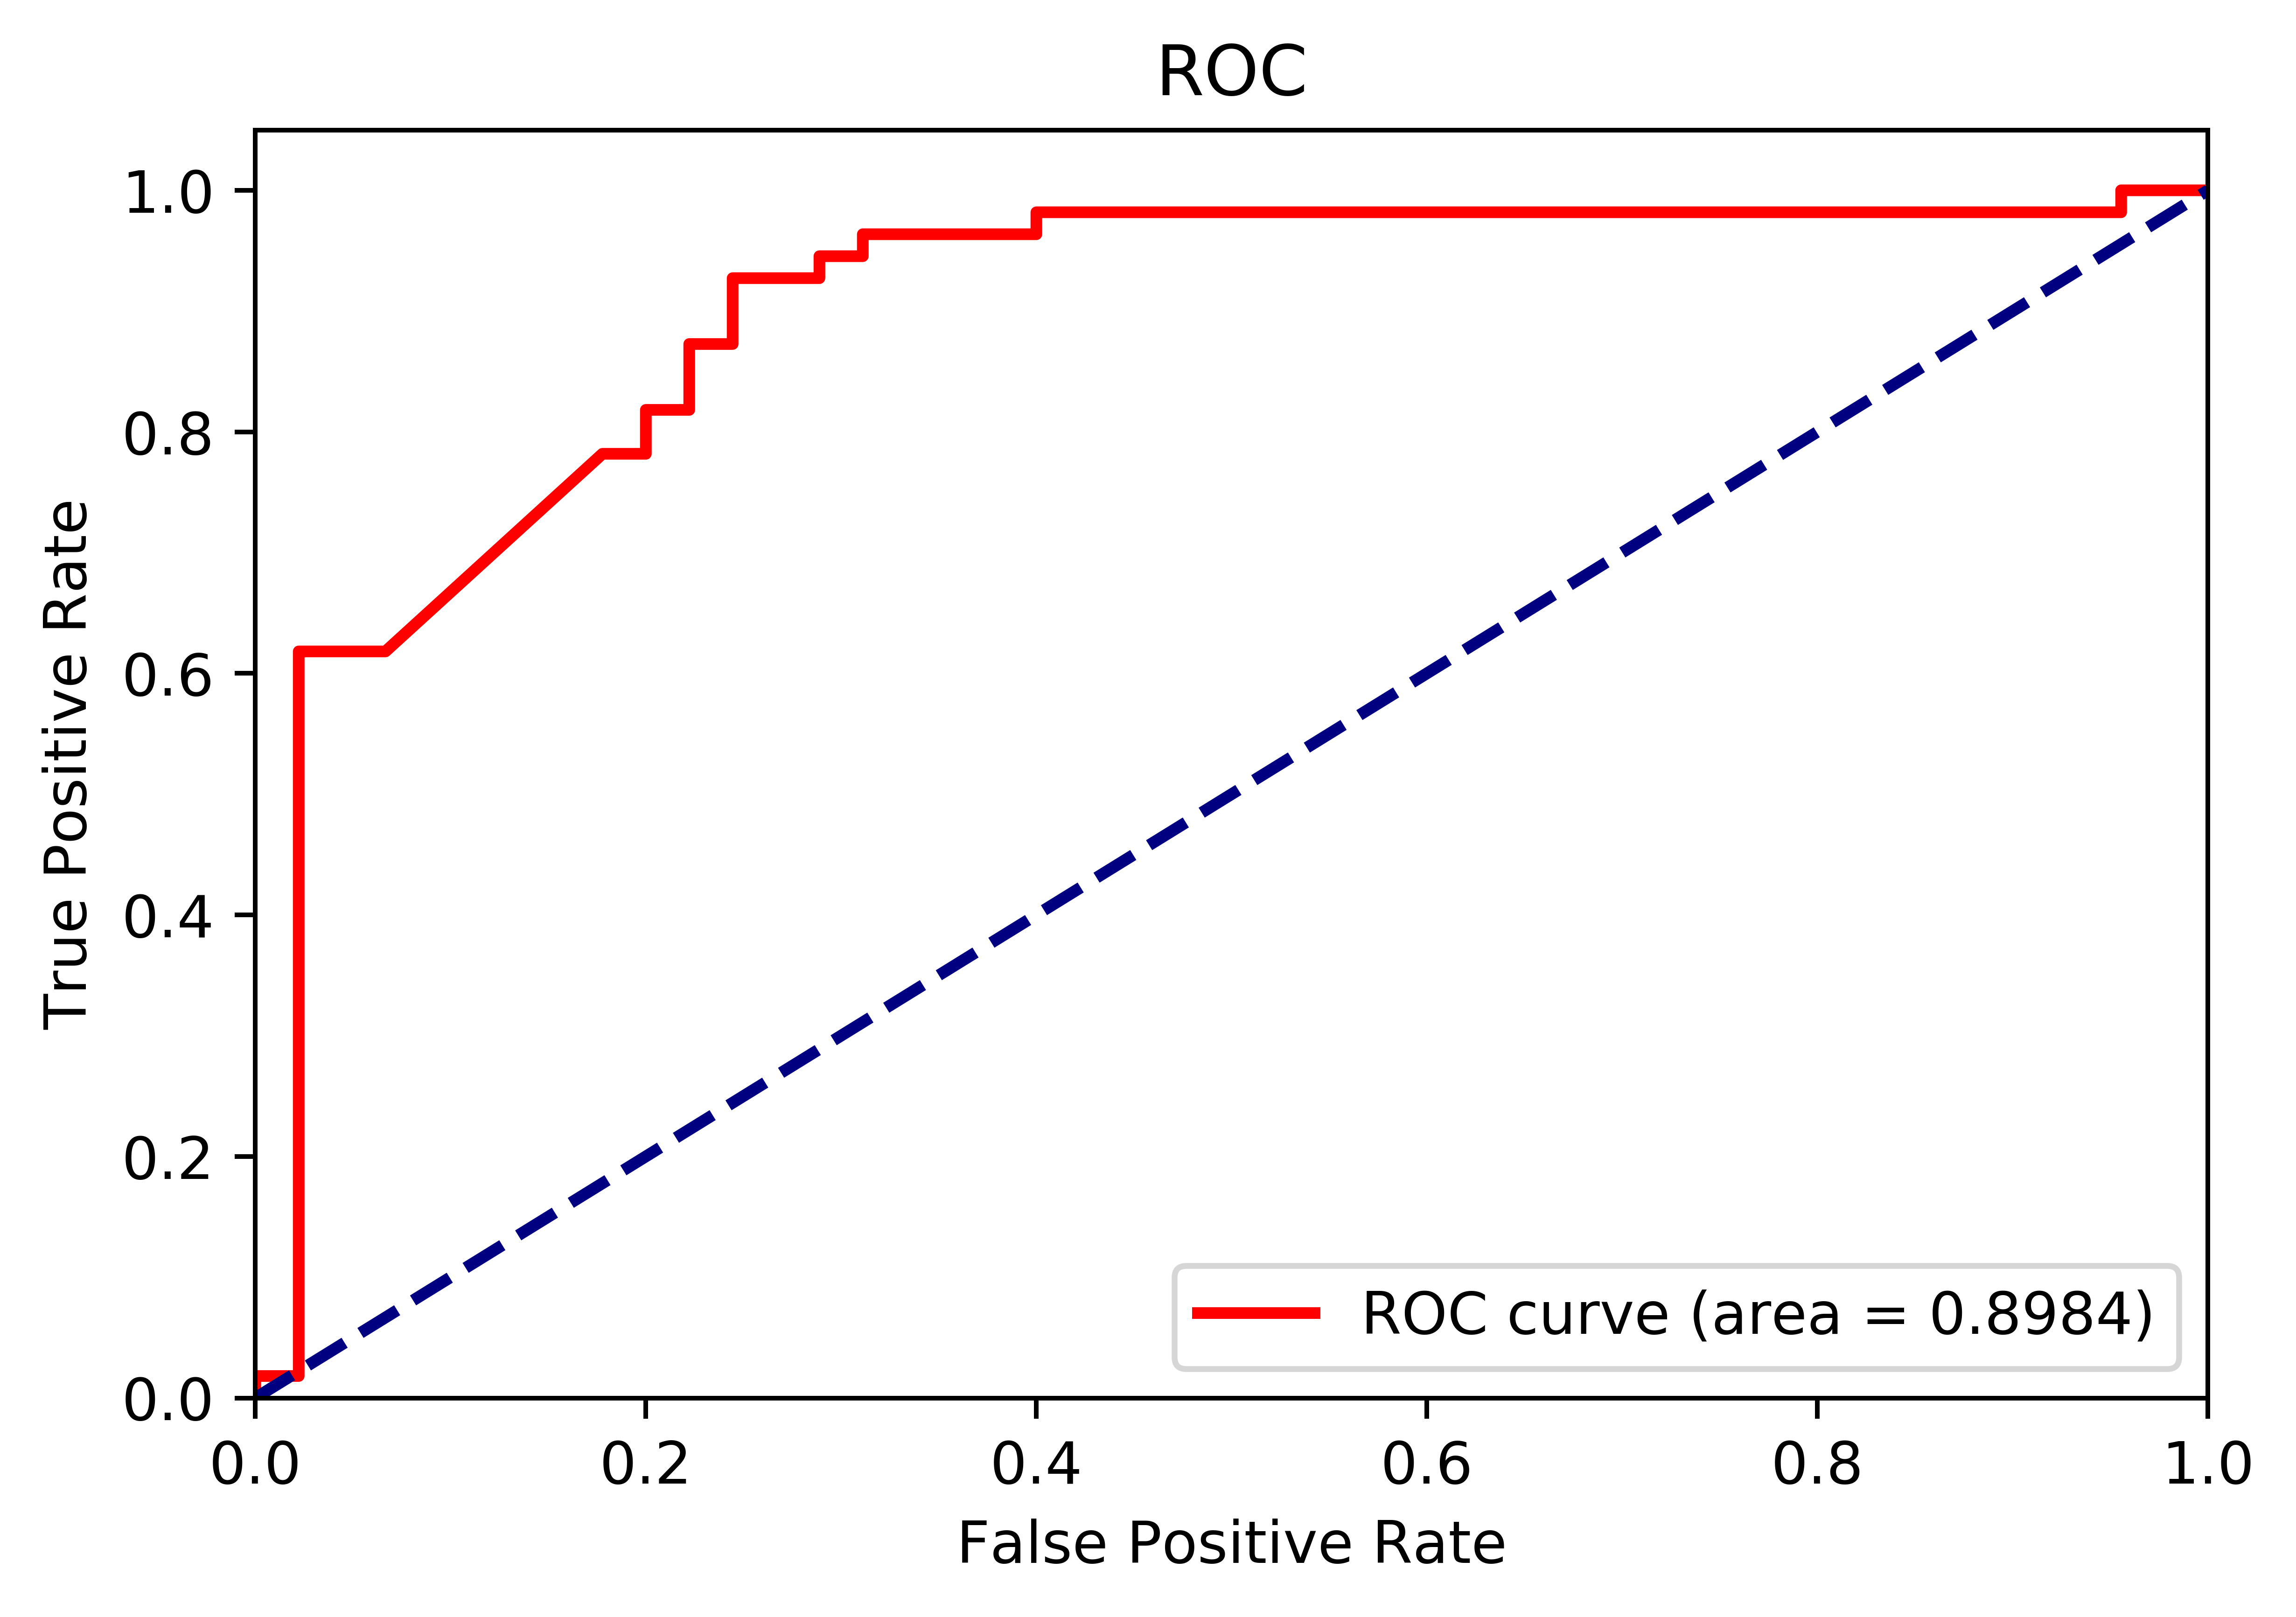

accuracy: 76.00%
recall: 61.82%
precision: 91.89%
f1: 73.91%


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import shuffle
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from collections import Counter

inputfile = 'C:/Users/wang/Desktop/Test_set_PseAAC_features.csv'
labels = ['positive', 'negative']
tick_marks = np.array(range(len(labels))) + 0.5

def readData():
    data = pd.read_csv(inputfile, encoding='utf8')
    data = data.values.astype(np.float32)
    shuffle(data)
    data_train = data[:int(1 * len(data)), :]
    return data_train

def train(data_train):
    x = data_train[:, 1:19] * 30
    y = data_train[:, 20].astype(int)
    return x, y

if __name__ == '__main__':
    data_train = readData()
    x, y = train(data_train)

    # 数据集划分
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # 画平均ROC曲线的两个参数
    clf1 = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    clf2 = MLPClassifier(
        hidden_layer_sizes=(100, 100, 50, 25),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    clf3 = MLPClassifier(
        hidden_layer_sizes=(100, 100, 50, 25),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    clf4 = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=420,
        max_iter=5000,
        learning_rate_init=0.001,
        momentum=0.9,
        batch_size=8,
        solver="adam",
        activation="relu"
    )

    # 使用投票分类器
    model = VotingClassifier(estimators=[('dnn1', clf1), ('dnn2', clf2), ('dnn3', clf3), ('dnn4', clf4)], voting='soft', weights=[1, 2, 2, 1])

    # 模型训练
    model.fit(x_train, y_train)

    # 模型预测
    probas_ = model.predict_proba(x_test)
    y_pred = model.predict(x_test)

    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)

    # 画ROC曲线
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig('Voting算法Test_set的PseAAC特征ROC曲线（无SMOTE算法）.jpg')
    plt.rcParams['figure.dpi'] = 900
    plt.show()

    # 输出评估结果
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: %.2f%%" % (accuracy * 100.0))

    recall = recall_score(y_test, y_pred)
    print("recall: %.2f%%" % (recall * 100.0))

    prec = precision_score(y_test, y_pred)
    print("precision: %.2f%%" % (prec * 100.0))

    f1 = f1_score(y_test, y_pred)
    print("f1: %.2f%%" % (f1 * 100.0))
